# 医学图像分割

## 写在前面
本项目采用的江苏大数据开发与应用大赛医疗图像赛道，作为医学分割任务入门试试水

unet3+ 参考：[unet3+](https://aistudio.baidu.com/aistudio/projectdetail/1555546?channel=0&channelType=0&shared=1)

大概以后会做医疗图像了，努力入门中



In [ ]:
!unzip -oq /home/aistudio/data/data100888/train.zip


In [ ]:
!unzip -oq /home/aistudio/data/data100888/test.zip

In [1]:
#安装 nii处理工具  SimpleITK 和分割工具paddleSeg
!pip install SimpleITK
!pip install paddleseg

Looking in indexes: https://mirror.baidu.com/pypi/simple/
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 194kB 17.2MB/s eta 0:00:01


In [2]:

!pip install tifffile

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 174kB 18.4MB/s eta 0:00:01


In [3]:
import tifffile as tif
from PIL import Image

In [4]:
#导入常用库

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import cv2

## unet3+训练

In [ ]:
def create_list(data_path):
    image_path = os.path.join(data_path, 'train_org_image')
    label_path = os.path.join(data_path, 'train_mask')
    data_names = os.listdir(image_path)
    random.shuffle(data_names)  # 打乱数据
    with open(os.path.join(data_path, 'train_list.txt'), 'w') as tf:
        with open(os.path.join(data_path, 'val_list.txt'), 'w') as vf:
            for idx, data_name in enumerate(data_names):
                img = os.path.join('train_org_image', data_name)
                lab = os.path.join('train_mask', data_name.replace('jpg', 'png'))
                if idx % 9 == 0:  # 90%的作为训练集
                    vf.write(img + ' ' + lab + '\n')
                else:
                    tf.write(img + ' ' + lab + '\n')
    print('数据列表生成完成')

data_path = 'train'
create_list(data_path)  # 生成数据列表

数据列表生成完成


In [ ]:
! pip install -q paddleseg

In [ ]:
import paddle
from paddleseg.models import UNet, UNetPlusPlus
from unet import UNet_3Plus
import paddleseg.transforms as T
from paddleseg.datasets import Dataset
from paddleseg.models.losses import BCELoss
from paddleseg.core import train

# 构建训练集
train_transforms = [
    T.RandomHorizontalFlip(),  # 水平翻转
    T.RandomVerticalFlip(),  # 垂直翻转
    T.RandomRotation(),  # 随机旋转
    T.RandomScaleAspect(),  # 随机缩放
    T.RandomDistort(),  # 随机扭曲
    T.Resize(target_size=(256, 256)),  # 这里为了加快速度，改为256x256
    T.Normalize()  # 归一化
]
train_dataset = Dataset(
    transforms=train_transforms,
    dataset_root='train',
    num_classes=2,
    mode='train',
    train_path='train/train_list.txt',
    #separator=' ',
)
# 构建验证集
val_transforms = [
    T.Resize(target_size=(256, 256)),
    T.Normalize()
]
val_dataset = Dataset(
    transforms=val_transforms,
    dataset_root='train',
    num_classes=2,
    mode='val',
    val_path='train/val_list.txt',
    #separator=' ',
)
# 优化器及损失
epochs = 30
batch_size = 1
iters = 43
base_lr = 2e-4
losses = {}
losses['types'] = [BCELoss()]
losses['coef'] = [1]

In [ ]:
unet_3p_model = UNet_3Plus(n_classes=2)
# paddle.summary(unet_3p_model, (16, 3, 256, 256))  # 查看网络结构
#lr = paddle.optimizer.lr.CosineAnnealingDecay(base_lr, T_max=(iters // 3), last_epoch=0.5)
lr=1e-4
u3p_optimizer = paddle.optimizer.Adam(lr, parameters=unet_3p_model.parameters())
# 训练
train(
    model=unet_3p_model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=u3p_optimizer,
    save_dir='output_u3p',
    iters=iters,
    batch_size=12,
    save_interval=int(iters/5),
    log_iters=100,
    num_workers=0,
    losses=losses,
    use_vdl=True)

2021-08-10 22:25:59 [INFO]	Start evaluating (total_samples: 197, total_iters: 197)...


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:239: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.int32, but right dtype is paddle.bool, the right dtype will convert to paddle.int32
  format(lhs_dtype, rhs_dtype, lhs_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:239: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.int64, but right dtype is paddle.bool, the right dtype will convert to paddle.int64
  format(lhs_dtype, rhs_dtype, lhs_dtype))
197/197 [==============================] - 20s 101ms/step - batch_cost: 0.0992 - reader cost: 0.050


2021-08-10 22:26:19 [INFO]	[EVAL] #Images: 197 mIoU: 0.0313 Acc: 0.0627 Kappa: 0.0000 
2021-08-10 22:26:19 [INFO]	[EVAL] Class IoU: 
[0.0627 0.    ]
2021-08-10 22:26:19 [INFO]	[EVAL] Class Acc: 
[1. 0.]
2021-08-10 22:26:24 [INFO]	[EVAL] The model with the best validation mIoU (0.0313) was saved at iter 8.
2021-08-10 22:26:49 [INFO]	Start evaluating (total_samples: 197, total_iters: 197)...


197/197 [==============================] - 17s 85ms/step - batch_cost: 0.0829 - reader cost: 0.04


2021-08-10 22:27:06 [INFO]	[EVAL] #Images: 197 mIoU: 0.4929 Acc: 0.9857 Kappa: 0.0000 
2021-08-10 22:27:06 [INFO]	[EVAL] Class IoU: 
[0.9857 0.    ]
2021-08-10 22:27:06 [INFO]	[EVAL] Class Acc: 
[1. 0.]
2021-08-10 22:27:11 [INFO]	[EVAL] The model with the best validation mIoU (0.4929) was saved at iter 16.
2021-08-10 22:27:29 [INFO]	Start evaluating (total_samples: 197, total_iters: 197)...


197/197 [==============================] - 20s 101ms/step - batch_cost: 0.0990 - reader cost: 0.04


2021-08-10 22:27:49 [INFO]	[EVAL] #Images: 197 mIoU: 0.4922 Acc: 0.9843 Kappa: 0.0000 
2021-08-10 22:27:49 [INFO]	[EVAL] Class IoU: 
[0.9843 0.    ]
2021-08-10 22:27:49 [INFO]	[EVAL] Class Acc: 
[1. 0.]
2021-08-10 22:27:53 [INFO]	[EVAL] The model with the best validation mIoU (0.4929) was saved at iter 16.
2021-08-10 22:28:21 [INFO]	Start evaluating (total_samples: 197, total_iters: 197)...


197/197 [==============================] - 17s 84ms/step - batch_cost: 0.0829 - reader cost: 0.04


2021-08-10 22:28:38 [INFO]	[EVAL] #Images: 197 mIoU: 0.4926 Acc: 0.9852 Kappa: 0.0000 
2021-08-10 22:28:38 [INFO]	[EVAL] Class IoU: 
[0.9852 0.    ]
2021-08-10 22:28:38 [INFO]	[EVAL] Class Acc: 
[1. 0.]
2021-08-10 22:28:42 [INFO]	[EVAL] The model with the best validation mIoU (0.4929) was saved at iter 16.
2021-08-10 22:29:07 [INFO]	Start evaluating (total_samples: 197, total_iters: 197)...


197/197 [==============================] - 17s 88ms/step - batch_cost: 0.0860 - reader cost: 0.036


2021-08-10 22:29:25 [INFO]	[EVAL] #Images: 197 mIoU: 0.4773 Acc: 0.9547 Kappa: 0.0000 
2021-08-10 22:29:25 [INFO]	[EVAL] Class IoU: 
[0.9547 0.    ]
2021-08-10 22:29:25 [INFO]	[EVAL] Class Acc: 
[1. 0.]
2021-08-10 22:29:28 [INFO]	[EVAL] The model with the best validation mIoU (0.4929) was saved at iter 16.
2021-08-10 22:29:32 [INFO]	Start evaluating (total_samples: 197, total_iters: 197)...


197/197 [==============================] - 15s 75ms/step - batch_cost: 0.0737 - reader cost: 0.034


2021-08-10 22:29:47 [INFO]	[EVAL] #Images: 197 mIoU: 0.4547 Acc: 0.9093 Kappa: 0.0000 
2021-08-10 22:29:47 [INFO]	[EVAL] Class IoU: 
[0.9093 0.    ]
2021-08-10 22:29:47 [INFO]	[EVAL] Class Acc: 
[1. 0.]
2021-08-10 22:29:51 [INFO]	[EVAL] The model with the best validation mIoU (0.4929) was saved at iter 16.
<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.fluid.dygraph.nn.BatchNorm'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
Cannot find suitable count function for <class 'paddle.nn.layer.common.Upsample'>. Treat it as zero FLOPs.
Total Flops: 478937088     Total Params: 26987714


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


## 效果展示

In [22]:
import numpy as np
import paddle
from paddleseg.models import UNet, UNetPlusPlus
from unet import UNet_3Plus
import paddleseg.transforms as T
from paddleseg.core import infer
from PIL import Image
import matplotlib.pyplot as plt

def nn_infer(model, img_path, model_path):
    # 网络定义
    para_state_dict = paddle.load(model_path)
    model.set_dict(para_state_dict)
    # 预测结果
    transforms = T.Compose([
        T.Resize(target_size=(256, 256)),
        T.Normalize()
    ])
    img, _ = transforms(img_path)
    img = paddle.to_tensor(img[np.newaxis, :])
    pre = infer.inference(model, img)
    pred = paddle.argmax(pre, axis=1).numpy().reshape((256, 256))
    return pred.astype('uint8')

img_path = 'train/train_org_image/hIeM9528.png'
lab_psth = 'train/train_mask/hIeM9528.png'

u3p_params = 'output_u3p/best_model/model.pdparams'

unet_3p_model = UNet_3Plus(n_classes=2)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since Num

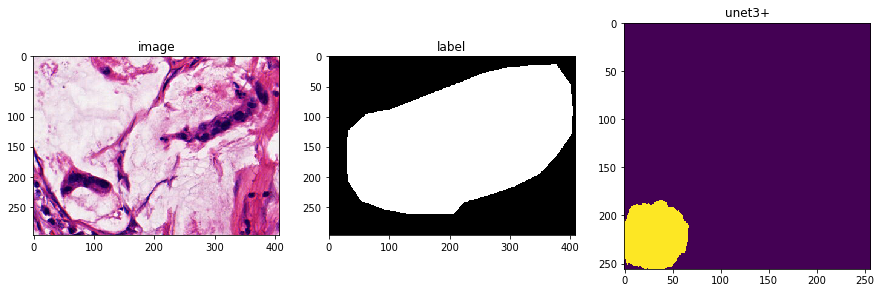

In [23]:
image = Image.open(img_path)
label = Image.open(lab_psth)

u3p_img = nn_infer(unet_3p_model, img_path, u3p_params)
plt.figure(figsize=(15, 10))
plt.subplot(131);plt.imshow(image);plt.title('image')
plt.subplot(132);plt.imshow(label);plt.title('label')

plt.subplot(133);plt.imshow(u3p_img);plt.title('unet3+')
plt.show()

### 预测并写入文件夹

In [40]:
!pip install scikit-image

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 29.2MB 8.2MB/s eta 0:00:011
     |████████████████████████████████| 4.4MB 14.0MB/s eta 0:00:01


In [41]:
import skimage.io as io

In [42]:
img_path= os.listdir('test/test_org_image')
u3p_params = 'output_u3p/best_model/model.pdparams'
unet_3p_model = UNet_3Plus(n_classes=2)
for filename in img_path:
    file_abs_path=os.path.join('test/test_org_image',filename)
    u3p_img = nn_infer(unet_3p_model, file_abs_path, u3p_params)
    file_write_path='test/test_label/{}'.format(str(filename))
    #u3p_img.save(u3p_img,file_write_path)
    #cv2.imwrite(u3p_img,file_write_path)
    io.imsave( file_write_path,u3p_img)


## 分类训练

In [12]:
! pip install paddlex==2.0.0rc3

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 839kB 13.5MB/s eta 0:00:01
     |████████████████████████████████| 1.0MB 12.4MB/s eta 0:00:01
     |████████████████████████████████| 6.8MB 28.5MB/s eta 0:00:01
     |████████████████████████████████| 1.5MB 25.4MB/s eta 0:00:01
     |████████████████████████████████| 307kB 27.9MB/s eta 0:00:01
     |████████████████████████████████| 153kB 21.6MB/s eta 0:00:01
     |████████████████████████████████| 51kB 12.8MB/s eta 0:00:01
     |████████████████████████████████| 286kB 25.7MB/s eta 0:00:01
     |████████████████████████████████| 102kB 22.9MB/s ta 0:00:01
     |████████████████████████████████| 102kB 23.8MB/s ta 0:00:01
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=278359 sha256=12ec545dbc88316b907c733b20f9562a70af2c5d1c4da7e272c0f1f9ac0b32eb
  Stored in directory: /home/aistudio/.cache/pip/wheels/fb/44/67/8baa69040569b1edbd7776ec6f82c387663e72

In [5]:
import os
import paddle
import paddle.vision.transforms as T
import numpy as np
from PIL import Image
import paddle.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import csv 
import random

In [ ]:
import pandas as pd

In [ ]:
just=pd.read_csv('train/train_label.csv')

In [ ]:
print(len(just))

1770


In [ ]:
print(just)

        image_name  label
0     DriTK8PS.png      1
1     DdoyknRO.png      1
2     mBaydeDo.png      1
3     YpTZltdj.png      1
4     P7vDwA9b.png      1
...            ...    ...
1765  TapibnkP.png      0
1766  uxqJo50K.png      0
1767  nN2SKhx5.png      0
1768  9evf8WAD.png      0
1769  3iOBGoMd.png      0

[1770 rows x 2 columns]


In [ ]:
csv_file = open('train/train_label.csv',encoding='utf-8')
csv_reader_lines = csv.reader(csv_file) 
for one_line in csv_reader_lines:
    print(one_line[0])
    break


image_name


In [ ]:
pd1=pd.read_csv('train/train_label.csv')
pd2=pd1.sample(frac=1)

pd3.to_csv('train/train_new.csv')


In [6]:
import csv    #加载csv包便于读取csv文件
dataset='train/train_org_image'
from sklearn.utils import shuffle
csv_file = open('train/train_new.csv',encoding='utf-8')    #打开csv文件

next(csv_file)
csv_reader_lines = csv.reader(csv_file)   #逐行读取csv文件

i=0
f1=open(f'train/train_label.txt',encoding='utf-8',mode='w')
f2=open(f'train/val_label.txt',encoding='utf-8',mode='w')

for one_line in csv_reader_lines:
    img=one_line[1]
    lab=one_line[2]
    if i <0.9*1770:
        f1.write( os.path.join(dataset,img) + '\t ' + lab + '\n')


                
    else:
        f2.write( os.path.join(dataset,img)+ ' \t' + lab + '\n')
    i+=1
f1.close()
f2.close()


   
    
        
        



In [7]:
# 测验下面类中__init__输出内容
with open(f'train/train_label.txt') as f:  # 查看文件内容
    for line in f.readlines():  # 逐行读取
        info = line.strip().split('\t')  # 以\t为切换符生成列表
        #print(info)
        if len(info) > 0:  # 列表不为空
            print(info[0].strip())  # 输出内容
       # break

In [8]:
with open(f'train/train_label.txt') as f:
            for line in f.readlines():
                info = line.strip().split('\t')
                print(info[0])
                break

train/train_org_image/n8rN7wmx.png


In [9]:
# 继承paddle.io.Dataset对数据集做处理
class CellDataset(paddle.io.Dataset):
    """
    数据集类的定义（注释见上方）
    """
    def __init__(self, mode='training_set'):
        """
        初始化函数
        """
        self.data = []
        with open(f'train/{mode}_label.txt') as f:
            for line in f.readlines():
                info = line.strip().split('\t')
                if len(info) > 0:
                    self.data.append([info[0].strip(), info[1].strip()]) #样本及标签
                      
    def __getitem__(self, index):
        """
        读取图片，对图片进行归一化处理，返回图片和 标签
        """
        image_file, label = self.data[index]  # 获取数据
        img = Image.open(image_file)  # 读取图片
        img = img.resize((100, 100), Image.ANTIALIAS)  # 图片大小样式归一化
        img = np.array(img).astype('float32')  # 转换成数组类型浮点型32位
        img = img.transpose((2, 0, 1))     #读出来的图像是rgb,rgb,rbg..., 转置为 rrr...,ggg...,bbb...
        img = img/255.0  # 数据缩放到0-1的范围
        return img, np.array(label, dtype='int64')

    def __len__(self):
        """
        获取样本总数
        """
        return len(self.data)

In [10]:
# 训练的数据提供器
train_dataset = CellDataset(mode='train')
# 测试的数据提供器
eval_dataset = CellDataset(mode='val')

# 查看训练和测试数据的大小
print('train大小：', train_dataset.__len__())
print('eval大小：', eval_dataset.__len__())

# 查看图片数据、大小及标签
for data, label in train_dataset:
    print(data)
    print(np.array(data).shape)
    print(label)
    break

train大小： 1593
eval大小： 177
[[[0.89411765 0.83137256 0.8509804  ... 0.8862745  0.8784314  0.87058824]
  [0.8745098  0.87058824 0.8901961  ... 0.8627451  0.9254902  0.8627451 ]
  [0.8627451  0.80784315 0.78039217 ... 0.9411765  0.91764706 0.827451  ]
  ...
  [0.9529412  0.9372549  0.93333334 ... 0.92156863 0.79607844 0.72156864]
  [0.9372549  0.94509804 0.9372549  ... 0.8117647  0.63529414 0.69803923]
  [0.85882354 0.89411765 0.9372549  ... 0.5686275  0.78431374 0.9254902 ]]

 [[0.7176471  0.52156866 0.58431375 ... 0.5921569  0.7137255  0.64705884]
  [0.5686275  0.52156866 0.5686275  ... 0.45490196 0.7372549  0.7411765 ]
  [0.5647059  0.49411765 0.40784314 ... 0.8745098  0.81960785 0.5176471 ]
  ...
  [0.9372549  0.8980392  0.8862745  ... 0.69411767 0.52156866 0.5882353 ]
  [0.9019608  0.9137255  0.89411765 ... 0.5921569  0.36078432 0.53333336]
  [0.8        0.85490197 0.90588236 ... 0.28235295 0.5372549  0.89411765]]

 [[0.84705883 0.7411765  0.7764706  ... 0.77254903 0.8352941  0.811764

### pdx读取训练集和验证集

In [13]:
import paddlex as pdx

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/distributed/parallel.py:120: UserWarning: Currently not a parallel execution environment, `paddle.distributed.init_parallel_env` will not do anything.
  "Currently not a parallel execution environment, `paddle.distributed.init_parallel_env` will not do anything."
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/parl/remote/communication.py:38: DeprecationWarning: 'pyarrow.default_serialization_context' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  context = pyarrow.default_serialization_context()


[08-12 14:04:28 MainThread @utils.py:79] WRN paddlepaddle version: 2.1.2. The dynamic graph version of PARL is under development, not fully tested and supported


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/pyarrow/pandas_compat.py:1027: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'floating': np.float,
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddleslim/common/analyze_helper.py:22: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/runpy.py"

In [ ]:
from paddlex import transforms as T

train_transforms = T.Compose(
    [T.RandomCrop(crop_size=224), T.RandomHorizontalFlip(), T.Normalize()])

eval_transforms = T.Compose([
    T.ResizeByShort(short_size=256), T.CenterCrop(crop_size=224), T.Normalize()
])

In [ ]:
train_dataset = pdx.datasets.ImageNet(
    data_dir='',
    file_list='train/train_label.txt',
    label_list='train/val_label.txt',
    transforms=train_transforms,
    shuffle=True)
    
eval_dataset = pdx.datasets.ImageNet(
    data_dir='',
    file_list='train/train_label.txt',
    label_list='train/val_label.txt',
    transforms=eval_transforms)

2021-08-11 16:01:22 [INFO]	Starting to read file list from dataset...
2021-08-11 16:01:22 [INFO]	1593 samples in file train/train_label.txt
2021-08-11 16:01:22 [INFO]	Starting to read file list from dataset...
2021-08-11 16:01:22 [INFO]	1593 samples in file train/train_label.txt


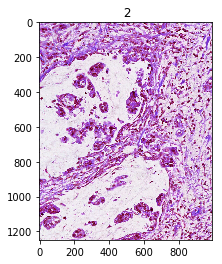

In [42]:

with open(f'train/train_label.txt') as f:  # 查看文件内容
    for line in f.readlines():  # 逐行读取
       info = line.strip().split('\t')  # 以\t为切换符生成列表
       im=cv2.imread(info[0])
       
       plt.imshow(im)
       plt.title(info[1])
       plt.show()
       break
      

       
       
      



### 模型训练

In [43]:
num_classes = len(train_dataset.labels)
model = pdx.cls.MobileNetV3_large_ssld(num_classes=num_classes)
model.train(num_epochs=12,
            train_dataset=train_dataset,
            train_batch_size=32,
            eval_dataset=eval_dataset,
            lr_decay_epochs=[6, 8],
            save_interval_epochs=1,
            learning_rate=0.00625,
            save_dir='output/mobilenetv3_large_ssld',
            use_vdl=True)

2021-08-11 16:06:22 [INFO]	Downloading MobileNetV3_large_x1_0_ssld_pretrained.pdparams from https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/MobileNetV3_large_x1_0_ssld_pretrained.pdparams


100%|██████████| 32444/32444 [00:00<00:00, 71059.01KB/s]


2021-08-11 16:06:22 [INFO]	Loading pretrained model from output/mobilenetv3_large_ssld/pretrain/MobileNetV3_large_x1_0_ssld_pretrained.pdparams
2021-08-11 16:06:22 [WARNING]	[SKIP] Shape of pretrained params out.weight doesn't match.(Pretrained: [1280, 1000], Actual: [1280, 177])
2021-08-11 16:06:22 [WARNING]	[SKIP] Shape of pretrained params out.bias doesn't match.(Pretrained: [1000], Actual: [177])
2021-08-11 16:06:22 [INFO]	There are 268/270 variables loaded into MobileNetV3_large_x1_0_ssld.
2021-08-11 16:06:32 [INFO]	[TRAIN] Epoch=1/12, Step=10/49, loss=0.413218, acc1=0.906250, acc5=1.000000, lr=0.006250, time_each_step=0.92s, eta=0:9:37
2021-08-11 16:06:41 [INFO]	[TRAIN] Epoch=1/12, Step=20/49, loss=0.258346, acc1=0.875000, acc5=1.000000, lr=0.006250, time_each_step=0.91s, eta=0:9:19
2021-08-11 16:06:52 [INFO]	[TRAIN] Epoch=1/12, Step=30/49, loss=0.089262, acc1=0.968750, acc5=1.000000, lr=0.006250, time_each_step=1.07s, eta=0:10:48
2021-08-11 16:07:00 [INFO]	[TRAIN] Epoch=1/12, St

### 预测
将预测结果写入CSV文件

2021-08-12 14:37:34 [INFO]	Model[MobileNetV3_large_ssld] loaded.
Predict Result: [{'category_id': 0, 'category': 'train/train_org_image/hJPXpfqc.png \t0', 'score': 1.0}]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


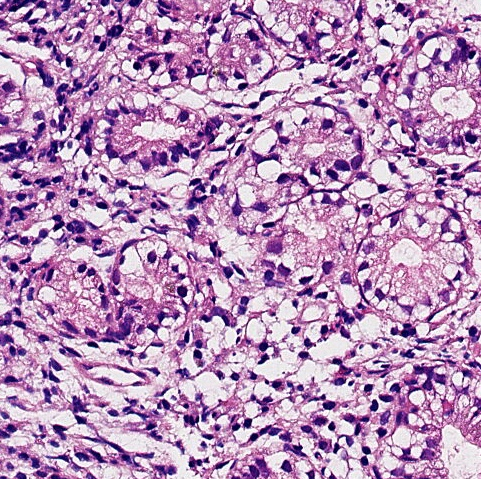

In [16]:
import paddlex as pdx
from PIL import Image
model = pdx.load_model('output/mobilenetv3_large_ssld/best_model')
image_name = 'test/test_org_image/ZajWD5gI.png'
result = model.predict(image_name)
print("Predict Result:", result)
Image.open('test/test_org_image/ZajWD5gI.png')

### 写入CSV文件

In [19]:
line1='%s,%s\n'%('img_name', 'label')
lines=[]
with open('csv_file_label.csv', 'w') as f:
        f.writelines(line1)
img_paths = os.listdir('test/test_org_image')
for filename in img_paths:
   file_abs_path = os.path.join('test/test_org_image', filename)
   file_predict_classes=model.predict(file_abs_path)

   line = '%s,%s\n'%(filename, file_predict_classes)
   lines.append(line)
   with open('csv_file_label.csv', 'a') as f:
        f.writelines(lines)



   

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


### 看一下预测结果

In [21]:
print(lines[1])

gwV50a4Z.png,[{'category_id': 1, 'category': 'train/train_org_image/EPQhSGBn.png \t1', 'score': 0.7621522}]

